In [1]:
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import List
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import os
import csv
import struct
import matplotlib.pyplot as plt

## 使用`torch`中`Dataset`类分别定义Iris数据类和MNIST数据类


In [2]:
class Iris(Dataset):
    def __init__(self, root='./iris.csv', split_ratio=0.4):
        self.name = {'setosa':0, 'versicolor':1, 'virginica':2}
        super(Iris,self).__init__()
        self.root = root
        self.x_train, self.y_train, \
                self.x_test, self.y_test = self._load_data(ratio=split_ratio)

    def _load_data(self, ratio=0.4):
        if not os.path.isfile(self.root):
            raise FileNotFoundError

        x = []
        y = []
        with open(self.root,'r') as f:
            reader = csv.reader(f)
            ## 跳过首行
            reader.__next__()
            for row in reader:
                x.append(list(map(float,row[1:-1])))
                y.append(float(self.name[row[-1]]))

        x = np.array(x).reshape(150,4)
        y = np.array(y).reshape(150,1)

        x1_train, x1_test, y1_train, y1_test = train_test_split(x[:50], y[:50], test_size=ratio)
        x2_train, x2_test, y2_train, y2_test = train_test_split(x[50:100], y[50:100], test_size=ratio)
        x3_train, x3_test, y3_train, y3_test = train_test_split(x[100:150], y[100:150], test_size=ratio)

        x_train = np.concatenate((x1_train,x2_train,x3_train), axis=0)
        y_train = np.concatenate((y1_train,y2_train,y3_train), axis=0)
        x_test = np.concatenate((x1_test,x2_test,x3_test), axis=0)
        y_test = np.concatenate((y1_test,y2_test,y3_test), axis=0)

        return x_train, y_train.astype(int), x_test, y_test.astype(int)

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, index: int):
        return self.x_train[index], self.y_train[index]

In [3]:
class MNIST(Dataset):
    def __init__(self, root='./MNIST'):
        '''
        方法说明:
            初始化类
        参数说明:
            root: 文件夹根目录
            image_file: mnist图像文件 'train-images.idx3-ubyte' 'test-images.idx3-ubyte'
            label_file: mnist标签文件 'train-labels.idx1-ubyte' 'test-labels.idx1-ubyte'
        '''
        super(Dataset,self).__init__()

        img_train_path = os.path.join(root, 'train-images.idx3-ubyte')
        label_train_path = os.path.join(root, 'train-labels.idx1-ubyte')
        img_test_path = os.path.join(root, 'test-images.idx3-ubyte')
        label_test_path = os.path.join(root, 'test-labels.idx1-ubyte')
        
        self.x_train = self._get_img(img_train_path)
        self.y_train = self._get_label(label_train_path)
        self.x_test = self._get_img(img_test_path)
        self.y_test = self._get_label(label_test_path)

    #读取图片
    def _get_img(self, path):

        with open(path,'rb') as fi:
            ImgFile = fi.read()
            head = struct.unpack_from('>IIII', ImgFile, 0)
            #定位数据开始位置
            offset = struct.calcsize('>IIII')
            ImgNum = head[1]
            width = head[2]
            height = head[3]
            #每张图片包含的像素点
            pixel = height*width
            bits = ImgNum * width * height
            bitsString = '>' + str(bits) + 'B'
            #读取文件信息
            images = struct.unpack_from(bitsString, ImgFile, offset)
            #转化为n*726矩阵
            images = np.reshape(images,[ImgNum,pixel])
        
        return images

    #读取标签
    def _get_label(self, path):

        with open(path,'rb') as fl:
            LableFile = fl.read()
            head = struct.unpack_from('>II', LableFile, 0)
            labelNum = head[1]
            #定位标签开始位置
            offset = struct.calcsize('>II')
            numString = '>' + str(labelNum) + "B"
            labels = struct.unpack_from(numString, LableFile, offset)
            #转化为1*n矩阵
            labels = np.reshape(labels, [labelNum])

        return labels

    #数据标准化
    def normalize(self, epsilon=1e-6):
        
        min = np.min(self.x_train, axis=0).reshape(1,-1)
        max = np.max(self.x_train, axis=0).reshape(1,-1)
        self.x_train = (self.x_train - min)/(max - min + epsilon)

        min = np.min(self.x_test, axis=0).reshape(1,-1)
        max = np.max(self.x_test, axis=0).reshape(1,-1)
        self.x_test = (self.x_test - min)/(max - min + epsilon)

    #数据归一化
    def standardlize(self, epsilon=1e-6):
        
        mean = np.mean(self.x_train, axis=0).reshape(1,-1)
        var = np.var(self.x_train, axis=0).reshape(1,-1)
        self.x_train = (self.x_train-mean)/(np.sqrt(var) + epsilon)

        mean = np.mean(self.x_test, axis=0).reshape(1,-1)
        var = np.var(self.x_test, axis=0).reshape(1,-1)
        self.x_test = (self.x_test-mean)/(np.sqrt(var) + epsilon)

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, index: int):
        return self.x_train[index], self.y_train[index]

## 定义模型


参数初始化

In [4]:
def init_weight(model):
    for layer in model.modules():
        if type(layer) in [nn.Linear, nn.Conv2d]:
            nn.init.xavier_normal_(layer.weight)

### 用于分类Iris数据集的全连接神经网络

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, layers:List, activation, bias=True):
        super(NeuralNetwork,self).__init__()

        architecture = []
        for i in range(1, len(layers)):
            architecture.append(nn.Linear(layers[i-1],layers[i],bias=bias))
            ## 最后一层不加激活函数
            if i < len(layers)-1:
                if activation == 'relu':
                    architecture.append(nn.ReLU())
                elif activation == 'sigmoid':
                    architecture.append(nn.Sigmoid())
                elif activation == 'tanh':
                    architecture.append(nn.Tanh())
                else:
                    raise

        self.fc = nn.Sequential(*architecture)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc(x)
        yhat = self.softmax(x)

        return yhat

### LeNet

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        
        self.avepool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.avepool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm1d(120)
        self.bn4 = nn.BatchNorm1d(84)


    def forward(self, x, batch_norm=False):
        x = F.sigmoid(self.conv1(x))
        if batch_norm:
            x = self.bn1(x)
        x = self.avepool1(x)

        x = F.sigmoid(self.conv2(x))
        if batch_norm:
            x = self.bn2(x)
        x = self.avepool2(x)

        x = x.view(-1,400)
        x = F.sigmoid(self.fc1(x))
        if batch_norm:
            x = self.bn3(x)
        x = F.sigmoid(self.fc2(x))
        if batch_norm:
            x = self.bn4(x)

        x = F.softmax(self.fc3(x), dim=-1)

        return x

## 模型训练


### 训练Iris数据集


In [7]:
def train_iris(model:nn.Module, dataset:Dataset, optimizer:optim.Optimizer, device,
                    epoch, batchsize, eval=True, log=True):

    dataloder = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    x_test, y_test = dataset.x_test, dataset.y_test

    acc_test = []
    acc_train = []
    losses = []

    for n_epoch in range(epoch):

        correct_train = torch.zeros(1).squeeze()
        loss_per_epoch = torch.zeros(1).squeeze()

        for i,(x,y) in enumerate(dataloder):
            x = x.float().to(device)
            y = y.squeeze().long().to(device)
            yhat = model(x)
            loss_train = F.cross_entropy(yhat, y)
            loss_per_epoch += loss_train.cpu()
            loss_train.backward()
            optimizer.step()

            prediction = torch.argmax(yhat, dim=-1)
            correct_train += (prediction == y).sum().float().cpu()
            
        loss_per_epoch = loss_per_epoch/ (i + 1)
        accuracy_train = correct_train / len(dataset)

        losses.append(loss_per_epoch)
        acc_train.append(accuracy_train)

        if eval:
            with torch.no_grad():
                x = torch.from_numpy(x_test).float().to(device)
                y = torch.from_numpy(y_test).long().squeeze().to(device)

                yhat = model(x)
                prediction = torch.argmax(yhat, dim=-1)
                correct_test = (prediction == y).sum().float().cpu()
                
                accuracy_test = correct_test / len(y)
                acc_test.append(accuracy_test)

        if log:
            print('epoch: %i/%i\t training loss %.2f\t training_acc %.2f\t val_acc %.2f'%
                        (n_epoch+1, epoch, loss_per_epoch, accuracy_train, accuracy_test))
        
    return model, losses, acc_train, acc_test

### 训练LeNet


In [8]:
def train_mnist(model:nn.Module, dataset:Dataset, optimizer:optim.Optimizer, device,
                    epoch, batchsize, norm=True, bacthnorm=True, eval=True, log=True):

    if norm:
        dataset.normalize()

    dataloder = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    x_test, y_test = dataset.x_test, dataset.y_test

    acc_test = []
    acc_train = []
    losses = []

    for n_epoch in range(epoch):

        correct_train = torch.zeros(1).squeeze()
        loss_per_epoch = torch.zeros(1).squeeze()

        for i,(x,y) in enumerate(dataloder):
            x = x.float().view(-1, 1, 28, 28).to(device)
            y = y.squeeze().long().to(device)
            yhat = model(x, batch_norm=bacthnorm)
            loss_train = F.cross_entropy(yhat, y)
            loss_per_epoch += loss_train.cpu()
            loss_train.backward()
            optimizer.step()

            prediction = torch.argmax(yhat, dim=-1)
            correct_train += (prediction == y).sum().float().cpu()
            
        loss_per_epoch = loss_per_epoch/ (i + 1)
        accuracy_train = correct_train / len(dataset)

        losses.append(loss_per_epoch)
        acc_train.append(accuracy_train)

        if eval:
            with torch.no_grad():
                x = torch.from_numpy(x_test).float().view(-1, 1, 28, 28).to(device)
                y = torch.from_numpy(y_test).long().squeeze().to(device)

                yhat = model(x, batch_norm=bacthnorm)
                prediction = torch.argmax(yhat, dim=-1)
                correct_test = (prediction == y).sum().float().cpu()
                
                accuracy_test = correct_test / len(y)
                acc_test.append(accuracy_test)

        if log:
            print('epoch: %i/%i\t training loss %.2f\t training_acc %.2f\t val_acc %.2f'%
                        (n_epoch+1, epoch, loss_per_epoch, accuracy_train, accuracy_test))
    
    return model, losses, acc_train, acc_test

检查GPU是否可用

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

device: cuda


设置超参数、模型实例化、数据集类实例化

In [16]:
root = './iris.csv'

## 超参数
layers = [4,10,10,3]
activation = 'sigmoid'
epoch = 100
lr = 0.1
momentum = 0
batchsize = 90
weight_decay = 0.1
log = False
## 模型初始化，定义数据集
model = NeuralNetwork(layers=layers, activation=activation)
model = model.to(device)
model.apply(init_weight)
iris_dataset = Iris(root=root, split_ratio=0.4)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

print(model)

NeuralNetwork(
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
  (softmax): Softmax(dim=-1)
)


训练模型

In [19]:
model, loss, acc_train, acc_test = train_iris(model, iris_dataset, optimizer, device, epoch, batchsize, log=log)

可视化损失函数及准确率

测试集准确率: 95.00 %


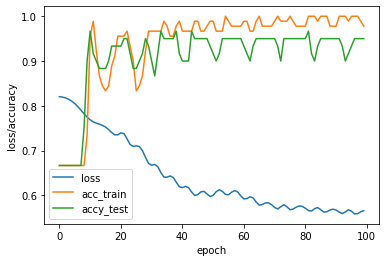

In [20]:
print('测试集准确率: %.2f %%'%float(acc_test[-1]*100))

iteration = np.arange(len(loss))
plt.plot(iteration, loss, label='loss')
plt.plot(iteration, acc_train, label='acc_train')
plt.plot(iteration, acc_test, label='accy_test')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend(loc='best')
plt.show()

LeNet超参数确定、数据集及模型初始化

In [21]:
root = './MNIST'

epoch = 10
lr = 0.001
momentum = 0
batchsize = 256
weight_decay = 0.1
norm = True
batchnorm = True

model = LeNet()
model = model.to(device)
model.apply(init_weight)
mnist_dataset = MNIST(root=root)
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr, weight_decay=weight_decay)

print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avepool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (avepool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


开始训练

In [22]:
model, loss, acc_train, acc_test = train_mnist(model, mnist_dataset, optimizer, device, epoch, batchsize, norm, batchnorm)

D:\anaconda3\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 1/10	 training loss 1.66	 training_acc 0.82	 val_acc 0.86
epoch: 2/10	 training loss 1.56	 training_acc 0.90	 val_acc 0.94
epoch: 3/10	 training loss 1.53	 training_acc 0.93	 val_acc 0.95
epoch: 4/10	 training loss 1.52	 training_acc 0.94	 val_acc 0.94
epoch: 5/10	 training loss 1.52	 training_acc 0.94	 val_acc 0.95
epoch: 6/10	 training loss 1.52	 training_acc 0.94	 val_acc 0.96
epoch: 7/10	 training loss 1.52	 training_acc 0.94	 val_acc 0.95
epoch: 8/10	 training loss 1.52	 training_acc 0.94	 val_acc 0.94
epoch: 9/10	 training loss 1.52	 training_acc 0.94	 val_acc 0.94
epoch: 10/10	 training loss 1.52	 training_acc 0.94	 val_acc 0.94


可视化模型结果

测试集准确率: 93.85 %


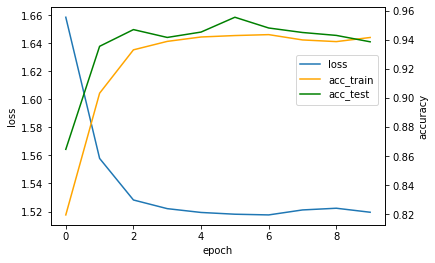

In [23]:
print('测试集准确率: %.2f %%'%float(acc_test[-1]*100))

iteration = np.arange(len(loss))

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(iteration, loss, label='loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

ax2 = ax1.twinx()
ax2.plot(iteration, acc_train, color='orange', label='acc_train')
ax2.plot(iteration, acc_test, color='green', label='acc_test')
ax2.set_ylabel('accuracy')

labels = []
lines = []
for ax in fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

fig.legend(lines, labels, loc=[0.68,0.6])
plt.show()

可视化分类结果

D:\anaconda3\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


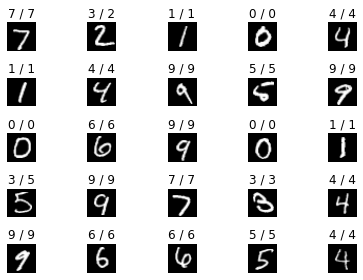

In [24]:
x_test = torch.Tensor(mnist_dataset.x_test[:25].reshape(25,1,28,28))
y_test = torch.Tensor(mnist_dataset.y_test[:25])

x_test = x_test.float().to(device)
y_test = y_test.to(device)

yhat = model(x_test, batch_norm=batchnorm)
yhat = torch.argmax(yhat, dim=-1)

x_test = x_test.cpu().numpy()
yhat = yhat.cpu().numpy()

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.title('%i / %i'%(yhat[i],y_test[i]))
    plt.imshow(x_test[i,0],cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()